## Animals-10

Animal pictures of 10 different categories taken from google images


It contains about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.

I have used it to test different image recognition networks: from homemade CNNs (~80% accuracy) to Google Inception (98%). It could simulate a smart gallery for a researcher (like a biologist).

All the images have been collected from "google images" and have been checked by human. There is some erroneous data to simulate real conditions (eg. images taken by users of your app).

The main directory is divided into folders, one for each category. Image count for each category varies from 2K to 5 K units.


https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os

In [201]:
path = '.\\Animals'

In [303]:
def get_working_dir(path):
    working_dir = []
    labels = []
    files = []
    for root, label, file in os.walk(path):
        working_dir.append(root)
        if len(label) != 0:
            labels.append(label)
        if len(file) != 0:
            files.append(file)
    return working_dir, labels, files

In [304]:
working_dir, labels, files = get_working_dir(path)

In [319]:
df = pd.DataFrame(files).transpose().astype(str)

In [320]:
labels[0]

['butterfly',
 'cat',
 'cow',
 'dog',
 'elephant',
 'horse',
 'rooster',
 'sheep',
 'spider',
 'squirrel']

In [321]:
df.columns = labels[0]

In [322]:
df = df.apply(lambda x: x.str[-15:])

In [323]:
df.head()

,butterfly,cat,cow,dog,elephant,horse,rooster,sheep,spider,squirrel
0,87ca3ed_640.jpg,1.jpeg,rXq6vAAAAA.jpeg,nAPPcUfOWQ.jpeg,aa5ecb6_640.jpg,-46_xwHaFj.jpeg,10.jpeg,8a0eabd_640.jpg,ba6ebb4_640.jpg,oHAOnAHaLJ.jpeg
1,87ca3ed_640.jpg,10.jpeg,ROPhGwHaFj.jpeg,pZOPswHaFS.jpeg,aa4e5b0_640.jpg,Y-pUdgHaFB.jpeg,100.jpeg,8a0eabd_640.jpg,ba6edbc_640.jpg,EXsO9AHaEk.jpeg
2,87ca3ed_640.jpg,100.jpeg,nYRTJQHaE7.jpeg,o9AqOQAAAA.jpeg,27ba6ee_640.jpg,ZbUVwgHaFi.jpeg,1000.jpeg,8a0eabd_640.jpg,5ecb5b1_640.jpg,QhEUDAHaE7.jpeg
3,87ca3ed_640.jpg,1001.jpeg,QUNgzgHaFj.jpeg,7zppcQHaFj.jpeg,aa4e5b0_640.jpg,tST_QwHaHa.jpeg,1001.jpeg,8a0eabd_640.jpg,5edb3bd_640.jpg,6vjkhwHaFk.jpeg
4,87ca3ed_640.jpg,1002.jpeg,fBRsBAHaE8.jpeg,WeF8-AHaFj.jpeg,aa4e5b0_640.jpg,p1S4WQHaJ3.jpeg,1010.jpeg,8a1ebb2_640.jpg,5ecb3b9_640.jpg,47smEwHaFj.jpeg


In [324]:
df = df.apply(lambda x: x.replace('None', np.nan))

In [331]:
df.count().to_frame().transpose()

,butterfly,cat,cow,dog,elephant,horse,rooster,sheep,spider,squirrel
0,2112,1668,1866,4863,1446,2623,3098,1820,4821,1862


In [333]:
df.isna().sum().to_frame().transpose()

,butterfly,cat,cow,dog,elephant,horse,rooster,sheep,spider,squirrel
0,2751,3195,2997,0,3417,2240,1765,3043,42,3001


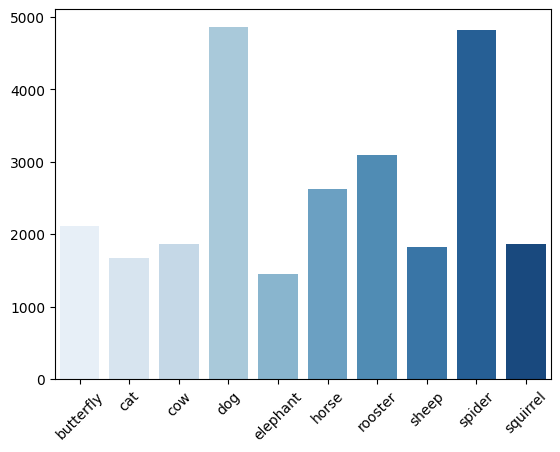

In [453]:
sns.barplot(x = df.count().index, y =df.count().values, palette = "Blues")
plt.xticks(rotation=45)
plt.show()

The dataset is quite __unbalanced__. In order to balance the dataset, in Keras'es model.fit function we can put dictionary with class weights:
<br>
<br>
__class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only).

In order to calculate weights easy, let's try to apply class weights for final training as per this info:

https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

In [467]:
import splitfolders
from keras_preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

In [456]:
splitfolders.ratio(path, path, ratio = (0.8, 0.15, 0.05))

In [464]:
train_dir = os.path.join(path+"\\train")
val_dir = os.path.join(path+"\\val")
test_dir = os.path.join(path+"\\test")

In [472]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='sparse',
                                                      target_size=(224, 224))

    validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='sparse',
                                                                target_size=(224, 224))
    
    
    ##########################################################
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)
    
    #########################################################

    train_class_weights = dict(enumerate(class_weights))

    return train_generator, validation_generator, train_class_weights

In [473]:
train_data, val_data, class_weights = train_val_generators(train_dir, val_dir)

Found 20938 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [505]:
weights = pd.DataFrame([train_data.class_indices.values(), train_data.class_indices.keys(), class_weights.values()]).transpose()

In [510]:
weights.columns = ('ClassIndice', 'ClassName', 'ClassWeight')

In [511]:
weights

,ClassIndice,ClassName,ClassWeight
0,0,butterfly,1.239668
1,1,cat,1.569565
2,2,cow,1.403351
3,3,dog,0.538252
4,4,elephant,1.811246
5,5,horse,0.997998
6,6,rooster,0.844956
7,7,sheep,1.438049
8,8,spider,0.542998
9,9,squirrel,1.406179


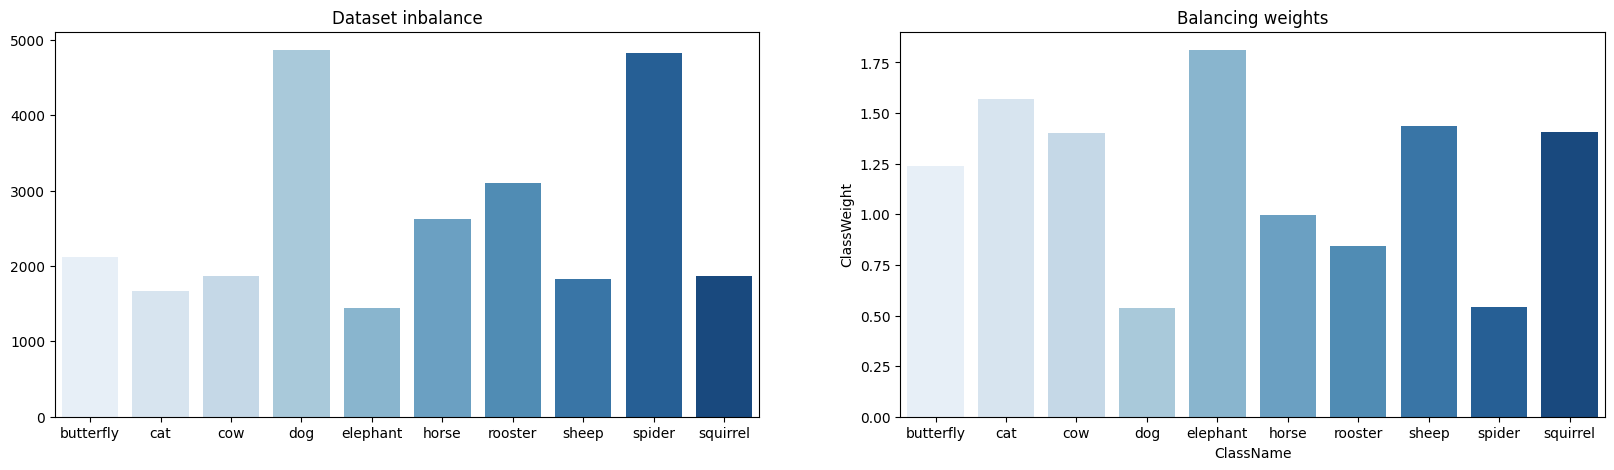

In [535]:
fig, (fig_1, fig_2) = plt.subplots(1,2, figsize=(20,5))

fig_1 = sns.barplot(x = df.count().index, y =df.count().values, palette = "Blues", ax=fig_1).set(title='Dataset inbalance')
fig_2 = sns.barplot(data=weights, x=weights.ClassName, y=weights.ClassWeight, palette = "Blues", ax=fig_2).set(title='Balancing weights')
plt.show()

We can see class'es weights to balance loss function during model.fit() function.

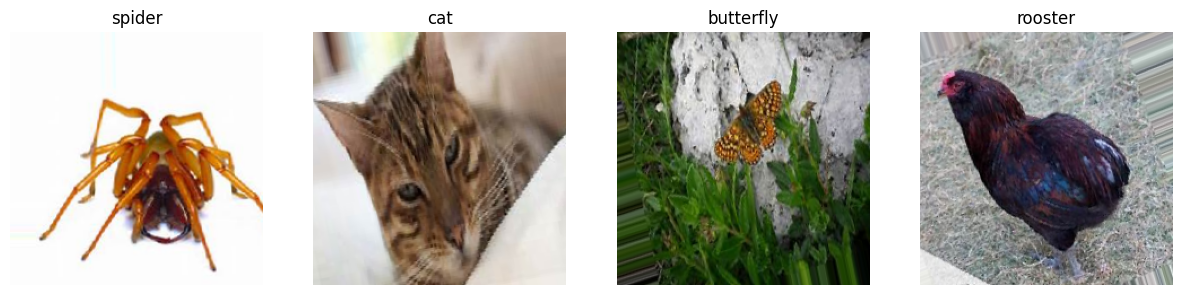

In [631]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

# generate batch of images
for i in range(4):
    image, label = train_data.next()
    
    titl = list(filter(lambda x: train_data.class_indices[x] == label[i], train_data.class_indices))[0]
   
    ax[i].set(title=titl)
    ax[i].imshow(image[i])
    ax[i].axis('off')

# Classification model

In [648]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.layers import GlobalAveragePooling2D as GAP, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.python.keras.layers.convolutional import Conv
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [660]:
class Classifier():   
    
    def __init__(self, base_model, model_name, train_set, valid_set, class_weights, epochs = 1, learning_rate = 1e-3):
        
        self.base_model = base_model
        self.model_name = model_name
        self.train_set = train_set
        self.valid_set = valid_set
        self.epochs = epochs
        self.class_weights = class_weights
        self.learning_rate = learning_rate
        
        # allow transfer learning
        
        self.base_model.trainable = True
        
        # create model 
        
        model = Sequential([
            Input(shape=(224, 224, 3)),
            BatchNormalization(),
            self.base_model,
            BatchNormalization(),
            GAP(),
            Dense(10, activation='Softmax')
        ])
        
        self.model = model
        self.model.summary()
        
        # compile model 
              
        self.model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      metrics=['accuracy'])
    
        # define callback
               
        callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
                     ModelCheckpoint(self.model_name+".h5", monitor="val_loss", save_best_only=True)]

        self.callbacks = callbacks   
        
        
    # defined as separated function for better handling and manipulation
    
    def model_fit(self):
        
        history = self.model.fit(self.train_set, validation_data = self.valid_set, callbacks=self.callbacks, epochs=self.epochs, 
                                 class_weight = self.class_weights)
        
        return history 

In [661]:
res_net_50 = Classifier(
base_model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet'), 
    model_name = 'ResNet50',
    train_set = train_data, 
    valid_set = val_data,
    class_weights = class_weights,
    epochs = 1,
    learning_rate = 1e-3
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 2048)       8192      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                      

In [ ]:
res_net_results = res_net_50.model_fit()

In [664]:
inception_V3 = Classifier(
base_model = tf.keras.applications.InceptionV3(include_top=False, weights = 'imagenet'),
    model_name = "Inception_V3",
    train_set = train_data,
    valid_set = val_data,
    class_weights = class_weights,
    epochs=1,
    learning_rate = 1e-3)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_104 (Ba  (None, 224, 224, 3)      12        
 tchNormalization)                                               
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 batch_normalization_105 (Ba  (None, 5, 5, 2048)       8192      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                      

In [ ]:
inception_V3_Results = inception_V3.model_fit()

In [667]:
mobile_net_v1 = Classifier(
base_model = tf.keras.applications.MobileNet(include_top = False, weights ='imagenet'),
    model_name = 'MobileNet',
    train_set = train_data,
    valid_set = val_data,
    class_weights = class_weights,
    epochs =1,
    learning_rate = 1e-3
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_106 (Ba  (None, 224, 224, 3)      12        
 tchNormalization)                                               
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 batch_normalization_107 (Ba  (None, 7, 7, 1024)       4096      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 10)               

In [ ]:
mobile_net_v1.model_fit()

In [668]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# !unzip '/content/gdrive/MyDrive/Animals.zip' -d '/content/Animals'

# path = '/content/Animals/Animals'

# train_dir = os.path.join(path+"/train/")
# val_dir = os.path.join(path+"/val/")
# test_dir = os.path.join(path+"/test/")